In [10]:
#=======================================
# Step-1: Import Libraries
#=======================================

import warnings
warnings.filterwarnings('ignore')

import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from tensorflow.keras.metrics import Precision,Recall

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


In [11]:
#======================================
# Step-2: folder path
#======================================

for dirname,_,filenames in os.walk('/kaggle/input'):
    if os.path.basename(dirname)=='Raw Data':
        print(dirname)

/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data


In [12]:
#==========================================================
# Step-3: Create Data frame using each file path & label
#==========================================================

base_dir='/kaggle/input/pmram-bangladeshi-brain-cancer-mri-dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Raw Data'
pattern=os.path.join(base_dir,'**','*.jpg')

filepaths=glob(pattern,recursive=True)

df=pd.DataFrame({
    'path':filepaths,
    'label':[os.path.basename(os.path.dirname(f)) for f in filepaths]
})

df


,path,label
0,/kaggle/input/pmram-bangladeshi-brain-cancer-m...,512Glioma
1,/kaggle/input/pmram-bangladeshi-brain-cancer-m...,512Glioma
2,/kaggle/input/pmram-bangladeshi-brain-cancer-m...,512Glioma
3,/kaggle/input/pmram-bangladeshi-brain-cancer-m...,512Glioma
4,/kaggle/input/pmram-bangladeshi-brain-cancer-m...,512Glioma
...,...,...
1500,/kaggle/input/pmram-bangladeshi-brain-cancer-m...,512Normal
1501,/kaggle/input/pmram-bangladeshi-brain-cancer-m...,512Normal
1502,/kaggle/input/pmram-bangladeshi-brain-cancer-m...,512Normal
1503,/kaggle/input/pmram-bangladeshi-brain-cancer-m...,512Normal


In [13]:
#unique label
df['label'].unique() 

array(['512Glioma', '512Meningioma', '512Pituitary', '512Normal'],
      dtype=object)

In [14]:
# label cleaning

df['label']=df['label'].map({
    '512Glioma':'Glioma',
    '512Meningioma':'Meningioma',
    '512Pituitary':'Pituitary',
    '512Normal':'Normal'
})

In [15]:
# check update label
df['label'].unique()

array(['Glioma', 'Meningioma', 'Pituitary', 'Normal'], dtype=object)

In [16]:

#======================================
# Image preprocessing( Augmentation)
#======================================

train_gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_gen=ImageDataGenerator(rescale=1./255)


In [17]:

#========================================
# Model build up function
#========================================

def build_model():

    base_model=VGG19(weights='imagenet',include_top=False,input_shape=IMG_SIZE+(3,),name='vgg19')
    base_model.trainable=False
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=BatchNormalization()(x)
    outputs=Dense(4,activation='softmax')(x)

    model=Model(base_model.input,outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy',Precision(),Recall()]
    )
    return model,base_model
    

In [18]:
#=====================================
# Step-4: K fold split
#=====================================

x=df['path'].values
y=df['label'].values

kf=KFold(n_splits=5,shuffle=True,random_state=42)

fold_no=1
results=[]

for train_idx,val_idx in kf.split(x):
    train_df=df.iloc[train_idx]
    val_df=df.iloc[val_idx]


    
    BATCH_SIZE=32
    SEED=42
    IMG_SIZE=(224,224)
    
    train_image=train_gen.flow_from_dataframe(
        train_df,
        x_col='path',
        y_col='label',
        target_size=IMG_SIZE,
        shuffle=True,
        batch_size=BATCH_SIZE,
        seed=SEED,
        class_mode='categorical'
    )

    val_image=val_gen.flow_from_dataframe(
        val_df,
        x_col='path',
        y_col='label',
        target_size=IMG_SIZE,
        shuffle=False,
        batch_size=BATCH_SIZE,
        seed=SEED,
        class_mode='categorical'
    )

    model,base_model=build_model()
    print('Fold-no: ', fold_no)

    er=EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    lr=ReduceLROnPlateau(
        monitor='val_loss',
        patience=2,
        factor=0.2,
        min_lr=1e-7,
        verbose=1
    )
    ck=ModelCheckpoint(
        f'best_model{fold_no}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
        
    )

    print('Fold no: ',fold_no)
    model.summary()
    model.fit(
        train_image,
        validation_data=val_image,
        epochs=10,
        callbacks=[ck,er,lr],
        verbose=1
    )

    base_model.trainable=True

    for layer in base_model.layers[:-30]:
        layer.trainable=False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy',Precision(),Recall()]
        
    )
    print('After fine tuning Fold no:  ',fold_no)
    model.summary()
    model.fit(
        train_image,
        validation_data=val_image,
        epochs=10,
        callbacks=[ck,lr,er],
        verbose=1
    )
    
    results.append(model.evaluate(val_image))
    fold_no+=1

print('\n final k-fold Results: ',results)

    
    

Found 1204 validated image filenames belonging to 4 classes.
Found 301 validated image filenames belonging to 4 classes.
Fold-no:  1
Fold no:  1


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 265,732 (1.01 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5093 - loss: 1.2134 - precision_10: 0.5738 - recall_10: 0.3926
Epoch 1: val_accuracy improved from -inf to 0.58472, saving model to best_model1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - accuracy: 0.5114 - loss: 1.2090 - precision_10: 0.5760 - recall_10: 0.3953 - val_accuracy: 0.5847 - val_loss: 1.0828 - val_precision_10: 0.9592 - val_recall_10: 0.1561 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7244 - loss: 0.7074 - precision_10: 0.7696 - recall_10: 0.6578
Epoch 2: val_accuracy improved from 0.58472 to 0.69435, saving model to best_model1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 418ms/step - accuracy: 0.7249 - loss: 0.7064 - precision_10: 0.7701 - recall_10: 0.6585 - val_accuracy: 0.6944 - val_loss: 0.9809 - val_precision_10: 0.9821 - val_recall_10: 0.1827 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7497 - loss: 0.6554 - precision_10: 0.7922 - recall_10: 0.6897
Epoch 3: val_accuracy improved from 0.69435 to 0.70100, saving model to best_model1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 418ms/step - accuracy: 0.7500 - loss: 0.6547 - precision_10: 0.7927 - recall_10: 0.6901 - val_accuracy: 0.7010 - val_loss: 0.9397 - val_precision_10: 0.9574 - val_recall_10: 0.2990 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8068 - loss: 0.5556 - precision_10: 0.8558 - recall_10: 0.7370
Epoch 4: val_accuracy improved from 0.70100 to 0.85714, saving model to best_model1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.8067 - loss: 0.5554 - precision_10: 0.8558 - recall_10: 0.7372 - val_accuracy: 0.8571 - val_loss: 0.8992 - val_precision_10: 0.9848 - val_recall_10: 0.2159 - learning_rate: 0.0010
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7973 - loss: 0.5723 - precision_10: 0.8477 - recall_10: 0.7294
Epoch 5: val_accuracy did not improve from 0.85714
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.7973 - loss: 0.5723 - precision_10: 0.8476 - recall_10: 0.7291 - val_accuracy: 0.8206 - val_loss: 0.8664 - val_precision_10: 0.9767 - val_recall_10: 0.2791 - learning_rate: 0.0010
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8045 - loss: 0.5520 - precision_10: 0.8633 - recall_10: 0.7297
Epoch 6: val_accuracy did not improve from 0.85714
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 410ms/step - accuracy: 0.8046 - loss: 0.5520 - precision_10: 0.8631 - recall_10: 0.7296 - val_accuracy: 0.8472 - val_loss: 0.8052 - val_p

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 20,290,116 (77.40 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.6486 - loss: 0.9227 - precision_11: 0.7074 - recall_11: 0.5561
Epoch 1: val_accuracy did not improve from 0.85714
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 552ms/step - accuracy: 0.6492 - loss: 0.9204 - precision_11: 0.7082 - recall_11: 0.5574 - val_accuracy: 0.3189 - val_loss: 4.1423 - val_precision_11: 0.3200 - val_recall_11: 0.3189 - learning_rate: 1.0000e-04
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8052 - loss: 0.5768 - precision_11: 0.8467 - recall_11: 0.7564
Epoch 2: val_accuracy did not improve from 0.85714
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 437ms/step - accuracy: 0.8054 - loss: 0.5757 - precision_11: 0.8467 - recall_11: 0.7570 - val_accuracy: 0.6645 - val_loss: 1.6332 - val_precision_11: 0.6806 - val_recall_11: 0.6512 - learning_rate: 1.0000e-04
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8758 - loss: 0.3774 - precision_11: 0.8914 - recall_11: 0.8457
Epoch 3: val_accuracy did not i

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 0.9529 - loss: 0.1289 - precision_11: 0.9600 - recall_11: 0.9492 - val_accuracy: 0.9535 - val_loss: 0.1744 - val_precision_11: 0.9599 - val_recall_11: 0.9535 - learning_rate: 1.0000e-04
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9526 - loss: 0.1282 - precision_11: 0.9553 - recall_11: 0.9493
Epoch 7: val_accuracy did not improve from 0.95349
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 417ms/step - accuracy: 0.9525 - loss: 0.1285 - precision_11: 0.9553 - recall_11: 0.9493 - val_accuracy: 0.7043 - val_loss: 1.5500 - val_precision_11: 0.7158 - val_recall_11: 0.6944 - learning_rate: 1.0000e-04
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9616 - loss: 0.1096 - precision_11: 0.9638 - recall_11: 0.9539
Epoch 8: val_accuracy did not improve from 0.95349

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 422ms/step - accuracy: 0.9615 - loss: 0.1097 - prec

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - accuracy: 0.9885 - loss: 0.0439 - precision_11: 0.9906 - recall_11: 0.9885 - val_accuracy: 0.9668 - val_loss: 0.1346 - val_precision_11: 0.9667 - val_recall_11: 0.9635 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 10.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9616 - loss: 0.2252 - precision_11: 0.9613 - recall_11: 0.9558
Found 1204 validated image filenames belonging to 4 classes.
Found 301 validated image filenames belonging to 4 classes.
Fold-no:  2
Fold no:  2


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 265,732 (1.01 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5016 - loss: 1.1756 - precision_12: 0.5598 - recall_12: 0.3812
Epoch 1: val_accuracy improved from -inf to 0.43522, saving model to best_model2.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - accuracy: 0.5035 - loss: 1.1719 - precision_12: 0.5621 - recall_12: 0.3837 - val_accuracy: 0.4352 - val_loss: 1.1187 - val_precision_12: 0.8675 - val_recall_12: 0.2392 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7100 - loss: 0.7365 - precision_12: 0.7793 - recall_12: 0.6382
Epoch 2: val_accuracy improved from 0.43522 to 0.86047, saving model to best_model2.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step - accuracy: 0.7100 - loss: 0.7363 - precision_12: 0.7794 - recall_12: 0.6382 - val_accuracy: 0.8605 - val_loss: 0.9824 - val_precision_12: 0.9800 - val_recall_12: 0.1628 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7798 - loss: 0.6034 - precision_12: 0.8482 - recall_12: 0.7218
Epoch 3: val_accuracy did not improve from 0.86047
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step - accuracy: 0.7800 - loss: 0.6032 - precision_12: 0.8481 - recall_12: 0.7217 - val_accuracy: 0.5349 - val_loss: 1.0165 - val_precision_12: 0.8804 - val_recall_12: 0.2691 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7972 - loss: 0.5636 - precision_12: 0.8601 - recall_12: 0.7149
Epoch 4: val_accuracy did not improve from 0.86047
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 390ms/step - accuracy: 0.7974 - loss: 0.5635 - precision_12: 0.8602 - recall_12: 0.7152 - val_accuracy: 0.6279 - val_loss: 0.9399 - val_p

38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 423ms/step - accuracy: 0.8072 - loss: 0.5595 - precision_12: 0.8559 - recall_12: 0.7305 - val_accuracy: 0.8771 - val_loss: 0.8436 - val_precision_12: 0.9756 - val_recall_12: 0.2658 - learning_rate: 0.0010
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8131 - loss: 0.5264 - precision_12: 0.8675 - recall_12: 0.7581
Epoch 6: val_accuracy did not improve from 0.87708
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 392ms/step - accuracy: 0.8131 - loss: 0.5267 - precision_12: 0.8675 - recall_12: 0.7577 - val_accuracy: 0.7076 - val_loss: 0.8145 - val_precision_12: 0.8488 - val_recall_12: 0.4850 - learning_rate: 0.0010
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8147 - loss: 0.5276 - precision_12: 0.8819 - recall_12: 0.7592
Epoch 7: val_accuracy did not improve from 0.87708
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 396ms/step - accuracy: 0.8148 - loss: 0.5274 - precision_12: 0.8817 - recall_12: 0.7591 - val_accuracy: 0.8671 - val_loss: 0.6493 - val_p

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 20,290,116 (77.40 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.6755 - loss: 0.8556 - precision_13: 0.7535 - recall_13: 0.5775
Epoch 1: val_accuracy did not improve from 0.87708
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 522ms/step - accuracy: 0.6761 - loss: 0.8537 - precision_13: 0.7539 - recall_13: 0.5784 - val_accuracy: 0.7375 - val_loss: 1.3658 - val_precision_13: 0.7457 - val_recall_13: 0.7209 - learning_rate: 1.0000e-04
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8220 - loss: 0.5086 - precision_13: 0.8602 - recall_13: 0.7816
Epoch 2: val_accuracy did not improve from 0.87708
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 431ms/step - accuracy: 0.8216 - loss: 0.5086 - precision_13: 0.8598 - recall_13: 0.7810 - val_accuracy: 0.8472 - val_loss: 0.4809 - val_precision_13: 0.8576 - val_recall_13: 0.8405 - learning_rate: 1.0000e-04
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8328 - loss: 0.4865 - precision_13: 0.8532 - recall_13: 0.8104
Epoch 3: val_accuracy did not i

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 443ms/step - accuracy: 0.9797 - loss: 0.0811 - precision_13: 0.9818 - recall_13: 0.9751 - val_accuracy: 0.9336 - val_loss: 0.1988 - val_precision_13: 0.9396 - val_recall_13: 0.9302 - learning_rate: 2.0000e-05
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9780 - loss: 0.0770 - precision_13: 0.9840 - recall_13: 0.9777
Epoch 7: val_accuracy improved from 0.93355 to 0.95349, saving model to best_model2.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 439ms/step - accuracy: 0.9778 - loss: 0.0772 - precision_13: 0.9838 - recall_13: 0.9775 - val_accuracy: 0.9535 - val_loss: 0.1815 - val_precision_13: 0.9565 - val_recall_13: 0.9502 - learning_rate: 2.0000e-05
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9864 - loss: 0.0566 - precision_13: 0.9864 - recall_13: 0.9834
Epoch 8: val_accuracy did not improve from 0.95349
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 430ms/step - accuracy: 0.9862 - loss: 0.0569 - precision_13: 0.9862 - recall_13: 0.9832 - val_accuracy: 0.9003 - val_loss: 0.2814 - val_precision_13: 0.9110 - val_recall_13: 0.8837 - learning_rate: 2.0000e-05
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9853 - loss: 0.0568 - precision_13: 0.9852 - recall_13: 0.9777
Epoch 9: val_accuracy improved from 0.95349 to 0.96013, saving model to best_model2.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 442ms/step - accuracy: 0.9853 - loss: 0.0569 - precision_13: 0.9852 - recall_13: 0.9777 - val_accuracy: 0.9601 - val_loss: 0.1557 - val_precision_13: 0.9631 - val_recall_13: 0.9535 - learning_rate: 2.0000e-05
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9805 - loss: 0.0575 - precision_13: 0.9821 - recall_13: 0.9792
Epoch 10: val_accuracy did not improve from 0.96013
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 422ms/step - accuracy: 0.9805 - loss: 0.0576 - precision_13: 0.9820 - recall_13: 0.9792 - val_accuracy: 0.9003 - val_loss: 0.2788 - val_precision_13: 0.9088 - val_recall_13: 0.8937 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 9.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9585 - loss: 0.1893 - precision_13: 0.9622 - recall_13: 0.9455
Found 1204 validated image filenames belonging to 4 classes.
Found 301 validated image filenames belonging to 4 classes.
Fold-no:  3
Fold no:  3


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 265,732 (1.01 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.4534 - loss: 1.2702 - precision_14: 0.5115 - recall_14: 0.3453
Epoch 1: val_accuracy improved from -inf to 0.41860, saving model to best_model3.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.4563 - loss: 1.2644 - precision_14: 0.5147 - recall_14: 0.3486 - val_accuracy: 0.4186 - val_loss: 1.1153 - val_precision_14: 0.8395 - val_recall_14: 0.2259 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7250 - loss: 0.7337 - precision_14: 0.7718 - recall_14: 0.6509
Epoch 2: val_accuracy improved from 0.41860 to 0.71096, saving model to best_model3.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step - accuracy: 0.7253 - loss: 0.7333 - precision_14: 0.7719 - recall_14: 0.6513 - val_accuracy: 0.7110 - val_loss: 0.9993 - val_precision_14: 1.0000 - val_recall_14: 0.0864 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7825 - loss: 0.5904 - precision_14: 0.8321 - recall_14: 0.7106
Epoch 3: val_accuracy improved from 0.71096 to 0.74751, saving model to best_model3.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.7824 - loss: 0.5908 - precision_14: 0.8321 - recall_14: 0.7106 - val_accuracy: 0.7475 - val_loss: 0.9610 - val_precision_14: 0.9265 - val_recall_14: 0.2093 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7893 - loss: 0.5718 - precision_14: 0.8439 - recall_14: 0.7239
Epoch 4: val_accuracy did not improve from 0.74751
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 394ms/step - accuracy: 0.7895 - loss: 0.5716 - precision_14: 0.8439 - recall_14: 0.7241 - val_accuracy: 0.7342 - val_loss: 0.9214 - val_precision_14: 0.9348 - val_recall_14: 0.2857 - learning_rate: 0.0010
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7972 - loss: 0.5468 - precision_14: 0.8592 - recall_14: 0.7390
Epoch 5: val_accuracy did not improve from 0.74751
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 397ms/step - accuracy: 0.7974 - loss: 0.5470 - precision_14: 0.8592 - recall_14: 0.7390 - val_accuracy: 0.6179 - val_loss: 0.9430 - val_p

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.8104 - loss: 0.5300 - precision_14: 0.8714 - recall_14: 0.7467 - val_accuracy: 0.8040 - val_loss: 0.8343 - val_precision_14: 0.9286 - val_recall_14: 0.3023 - learning_rate: 0.0010
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7934 - loss: 0.5359 - precision_14: 0.8468 - recall_14: 0.7417
Epoch 7: val_accuracy did not improve from 0.80399
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step - accuracy: 0.7935 - loss: 0.5360 - precision_14: 0.8469 - recall_14: 0.7416 - val_accuracy: 0.7475 - val_loss: 0.7639 - val_precision_14: 0.9241 - val_recall_14: 0.4850 - learning_rate: 0.0010
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8342 - loss: 0.5001 - precision_14: 0.8804 - recall_14: 0.7756
Epoch 8: val_accuracy did not improve from 0.80399
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 389ms/step - accuracy: 0.8340 - loss: 0.5006 - precision_14: 0.8803 - recall_14: 0.7751 - val_accuracy: 0.7940 - val_loss: 0.6994 - val_p

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 20,290,116 (77.40 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7002 - loss: 0.8209 - precision_15: 0.7480 - recall_15: 0.6201
Epoch 1: val_accuracy did not improve from 0.80399
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 558ms/step - accuracy: 0.7002 - loss: 0.8201 - precision_15: 0.7479 - recall_15: 0.6206 - val_accuracy: 0.5382 - val_loss: 2.9580 - val_precision_15: 0.5400 - val_recall_15: 0.5382 - learning_rate: 1.0000e-04
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8288 - loss: 0.4649 - precision_15: 0.8567 - recall_15: 0.7878
Epoch 2: val_accuracy did not improve from 0.80399
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 419ms/step - accuracy: 0.8292 - loss: 0.4641 - precision_15: 0.8572 - recall_15: 0.7883 - val_accuracy: 0.6113 - val_loss: 1.4046 - val_precision_15: 0.6122 - val_recall_15: 0.5980 - learning_rate: 1.0000e-04
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8582 - loss: 0.3677 - precision_15: 0.8887 - recall_15: 0.8425
Epoch 3: val_accuracy did not i

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 441ms/step - accuracy: 0.9101 - loss: 0.2241 - precision_15: 0.9282 - recall_15: 0.8984 - val_accuracy: 0.8771 - val_loss: 0.4038 - val_precision_15: 0.8912 - val_recall_15: 0.8704 - learning_rate: 2.0000e-05
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9722 - loss: 0.0996 - precision_15: 0.9752 - recall_15: 0.9672
Epoch 6: val_accuracy improved from 0.87708 to 0.89701, saving model to best_model3.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 426ms/step - accuracy: 0.9720 - loss: 0.0998 - precision_15: 0.9751 - recall_15: 0.9670 - val_accuracy: 0.8970 - val_loss: 0.3961 - val_precision_15: 0.9054 - val_recall_15: 0.8904 - learning_rate: 2.0000e-05
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9592 - loss: 0.0868 - precision_15: 0.9647 - recall_15: 0.9548
Epoch 7: val_accuracy improved from 0.89701 to 0.91694, saving model to best_model3.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 442ms/step - accuracy: 0.9596 - loss: 0.0866 - precision_15: 0.9650 - recall_15: 0.9552 - val_accuracy: 0.9169 - val_loss: 0.3446 - val_precision_15: 0.9200 - val_recall_15: 0.9169 - learning_rate: 2.0000e-05
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9751 - loss: 0.0665 - precision_15: 0.9779 - recall_15: 0.9717
Epoch 8: val_accuracy improved from 0.91694 to 0.93688, saving model to best_model3.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 442ms/step - accuracy: 0.9752 - loss: 0.0665 - precision_15: 0.9780 - recall_15: 0.9717 - val_accuracy: 0.9369 - val_loss: 0.2866 - val_precision_15: 0.9398 - val_recall_15: 0.9336 - learning_rate: 2.0000e-05
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9676 - loss: 0.0782 - precision_15: 0.9749 - recall_15: 0.9662
Epoch 9: val_accuracy did not improve from 0.93688
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 434ms/step - accuracy: 0.9676 - loss: 0.0784 - precision_15: 0.9749 - recall_15: 0.9661 - val_accuracy: 0.8937 - val_loss: 0.3738 - val_precision_15: 0.8960 - val_recall_15: 0.8870 - learning_rate: 2.0000e-05
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9890 - loss: 0.0592 - precision_15: 0.9891 - recall_15: 0.9838
Epoch 10: val_accuracy did not improve from 0.93688

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 419ms/step - accuracy: 0.9889 - loss: 0.0593 - pr

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 265,732 (1.01 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.4501 - loss: 1.2854 - precision_16: 0.5340 - recall_16: 0.3500
Epoch 1: val_accuracy improved from -inf to 0.63787, saving model to best_model4.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.4530 - loss: 1.2792 - precision_16: 0.5371 - recall_16: 0.3531 - val_accuracy: 0.6379 - val_loss: 1.1209 - val_precision_16: 0.9737 - val_recall_16: 0.1229 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7336 - loss: 0.7040 - precision_16: 0.7855 - recall_16: 0.6355
Epoch 2: val_accuracy improved from 0.63787 to 0.75415, saving model to best_model4.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.7336 - loss: 0.7041 - precision_16: 0.7855 - recall_16: 0.6356 - val_accuracy: 0.7542 - val_loss: 1.0192 - val_precision_16: 0.9783 - val_recall_16: 0.1495 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7873 - loss: 0.5883 - precision_16: 0.8438 - recall_16: 0.7193
Epoch 3: val_accuracy did not improve from 0.75415
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 395ms/step - accuracy: 0.7870 - loss: 0.5889 - precision_16: 0.8435 - recall_16: 0.7188 - val_accuracy: 0.6213 - val_loss: 1.0197 - val_precision_16: 0.9692 - val_recall_16: 0.2093 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8001 - loss: 0.5527 - precision_16: 0.8691 - recall_16: 0.7120
Epoch 4: val_accuracy did not improve from 0.75415
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 399ms/step - accuracy: 0.8001 - loss: 0.5528 - precision_16: 0.8692 - recall_16: 0.7122 - val_accuracy: 0.6744 - val_loss: 0.9331 - val_p

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 399ms/step - accuracy: 0.7711 - loss: 0.6010 - precision_16: 0.8306 - recall_16: 0.6998 - val_accuracy: 0.7575 - val_loss: 0.8655 - val_precision_16: 0.9444 - val_recall_16: 0.3389 - learning_rate: 0.0010
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8133 - loss: 0.5376 - precision_16: 0.8728 - recall_16: 0.7503
Epoch 6: val_accuracy improved from 0.75748 to 0.77741, saving model to best_model4.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 407ms/step - accuracy: 0.8133 - loss: 0.5377 - precision_16: 0.8726 - recall_16: 0.7503 - val_accuracy: 0.7774 - val_loss: 0.7636 - val_precision_16: 0.9615 - val_recall_16: 0.4983 - learning_rate: 0.0010
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8122 - loss: 0.5316 - precision_16: 0.8654 - recall_16: 0.7519
Epoch 7: val_accuracy improved from 0.77741 to 0.83389, saving model to best_model4.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 402ms/step - accuracy: 0.8124 - loss: 0.5314 - precision_16: 0.8655 - recall_16: 0.7519 - val_accuracy: 0.8339 - val_loss: 0.6931 - val_precision_16: 0.9515 - val_recall_16: 0.5216 - learning_rate: 0.0010
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8252 - loss: 0.5229 - precision_16: 0.8767 - recall_16: 0.7558
Epoch 8: val_accuracy improved from 0.83389 to 0.84053, saving model to best_model4.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 403ms/step - accuracy: 0.8254 - loss: 0.5220 - precision_16: 0.8766 - recall_16: 0.7561 - val_accuracy: 0.8405 - val_loss: 0.5597 - val_precision_16: 0.9351 - val_recall_16: 0.7176 - learning_rate: 0.0010
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8397 - loss: 0.4696 - precision_16: 0.8790 - recall_16: 0.7861
Epoch 9: val_accuracy improved from 0.84053 to 0.85382, saving model to best_model4.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.8394 - loss: 0.4701 - precision_16: 0.8788 - recall_16: 0.7858 - val_accuracy: 0.8538 - val_loss: 0.5910 - val_precision_16: 0.9340 - val_recall_16: 0.6578 - learning_rate: 0.0010
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8349 - loss: 0.4691 - precision_16: 0.8621 - recall_16: 0.7798
Epoch 10: val_accuracy did not improve from 0.85382

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 389ms/step - accuracy: 0.8346 - loss: 0.4693 - precision_16: 0.8622 - recall_16: 0.7796 - val_accuracy: 0.7841 - val_loss: 0.6522 - val_precision_16: 0.8205 - val_recall_16: 0.6379 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 8.
After fine tuning Fold no:   4


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 20,290,116 (77.40 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.6388 - loss: 0.8972 - precision_17: 0.6939 - recall_17: 0.5614
Epoch 1: val_accuracy did not improve from 0.85382
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 552ms/step - accuracy: 0.6400 - loss: 0.8945 - precision_17: 0.6953 - recall_17: 0.5627 - val_accuracy: 0.4153 - val_loss: 3.0356 - val_precision_17: 0.4192 - val_recall_17: 0.4053 - learning_rate: 1.0000e-04
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7773 - loss: 0.6184 - precision_17: 0.8049 - recall_17: 0.7426
Epoch 2: val_accuracy did not improve from 0.85382
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 434ms/step - accuracy: 0.7780 - loss: 0.6169 - precision_17: 0.8056 - recall_17: 0.7434 - val_accuracy: 0.6246 - val_loss: 1.8262 - val_precision_17: 0.6237 - val_recall_17: 0.6113 - learning_rate: 1.0000e-04
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8478 - loss: 0.4289 - precision_17: 0.8702 - recall_17: 0.8335
Epoch 3: val_accuracy did not i

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 453ms/step - accuracy: 0.9512 - loss: 0.1352 - precision_17: 0.9579 - recall_17: 0.9503 - val_accuracy: 0.9203 - val_loss: 0.2403 - val_precision_17: 0.9231 - val_recall_17: 0.9169 - learning_rate: 2.0000e-05
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9778 - loss: 0.0753 - precision_17: 0.9788 - recall_17: 0.9732
Epoch 9: val_accuracy did not improve from 0.92027
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 427ms/step - accuracy: 0.9777 - loss: 0.0755 - precision_17: 0.9788 - recall_17: 0.9732 - val_accuracy: 0.6346 - val_loss: 1.5670 - val_precision_17: 0.6346 - val_recall_17: 0.6346 - learning_rate: 2.0000e-05
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9647 - loss: 0.0999 - precision_17: 0.9676 - recall_17: 0.9609
Epoch 10: val_accuracy improved from 0.92027 to 0.95349, saving model to best_model4.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 449ms/step - accuracy: 0.9651 - loss: 0.0992 - precision_17: 0.9680 - recall_17: 0.9612 - val_accuracy: 0.9535 - val_loss: 0.1514 - val_precision_17: 0.9562 - val_recall_17: 0.9435 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 10.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9499 - loss: 0.1606 - precision_17: 0.9527 - recall_17: 0.9411
Found 1204 validated image filenames belonging to 4 classes.
Found 301 validated image filenames belonging to 4 classes.
Fold-no:  5
Fold no:  5


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 265,732 (1.01 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.4650 - loss: 1.2294 - precision_18: 0.5305 - recall_18: 0.3509
Epoch 1: val_accuracy improved from -inf to 0.44518, saving model to best_model5.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - accuracy: 0.4681 - loss: 1.2232 - precision_18: 0.5339 - recall_18: 0.3545 - val_accuracy: 0.4452 - val_loss: 1.1154 - val_precision_18: 0.7619 - val_recall_18: 0.2658 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7269 - loss: 0.6848 - precision_18: 0.7829 - recall_18: 0.6377
Epoch 2: val_accuracy improved from 0.44518 to 0.57807, saving model to best_model5.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.7269 - loss: 0.6847 - precision_18: 0.7831 - recall_18: 0.6380 - val_accuracy: 0.5781 - val_loss: 1.0471 - val_precision_18: 0.9355 - val_recall_18: 0.1927 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7688 - loss: 0.6454 - precision_18: 0.8207 - recall_18: 0.6931
Epoch 3: val_accuracy improved from 0.57807 to 0.65116, saving model to best_model5.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 410ms/step - accuracy: 0.7686 - loss: 0.6450 - precision_18: 0.8206 - recall_18: 0.6931 - val_accuracy: 0.6512 - val_loss: 0.9702 - val_precision_18: 0.8902 - val_recall_18: 0.2425 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7637 - loss: 0.6231 - precision_18: 0.8199 - recall_18: 0.6771
Epoch 4: val_accuracy improved from 0.65116 to 0.74086, saving model to best_model5.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 399ms/step - accuracy: 0.7642 - loss: 0.6222 - precision_18: 0.8203 - recall_18: 0.6777 - val_accuracy: 0.7409 - val_loss: 0.9074 - val_precision_18: 0.9663 - val_recall_18: 0.2857 - learning_rate: 0.0010
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7683 - loss: 0.6000 - precision_18: 0.8327 - recall_18: 0.6947
Epoch 5: val_accuracy improved from 0.74086 to 0.82724, saving model to best_model5.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step - accuracy: 0.7685 - loss: 0.6000 - precision_18: 0.8330 - recall_18: 0.6949 - val_accuracy: 0.8272 - val_loss: 0.8473 - val_precision_18: 0.9785 - val_recall_18: 0.3023 - learning_rate: 0.0010
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8294 - loss: 0.5360 - precision_18: 0.8784 - recall_18: 0.7600
Epoch 6: val_accuracy did not improve from 0.82724
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 392ms/step - accuracy: 0.8291 - loss: 0.5359 - precision_18: 0.8783 - recall_18: 0.7596 - val_accuracy: 0.6944 - val_loss: 0.8309 - val_precision_18: 0.8824 - val_recall_18: 0.3987 - learning_rate: 0.0010
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8090 - loss: 0.5465 - precision_18: 0.8631 - recall_18: 0.7292
Epoch 7: val_accuracy improved from 0.82724 to 0.84053, saving model to best_model5.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step - accuracy: 0.8092 - loss: 0.5464 - precision_18: 0.8630 - recall_18: 0.7293 - val_accuracy: 0.8405 - val_loss: 0.7584 - val_precision_18: 0.9583 - val_recall_18: 0.4585 - learning_rate: 0.0010
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8274 - loss: 0.5089 - precision_18: 0.8812 - recall_18: 0.7464
Epoch 8: val_accuracy did not improve from 0.84053
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step - accuracy: 0.8271 - loss: 0.5095 - precision_18: 0.8809 - recall_18: 0.7460 - val_accuracy: 0.8106 - val_loss: 0.6905 - val_precision_18: 0.9351 - val_recall_18: 0.5748 - learning_rate: 0.0010
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8231 - loss: 0.5071 - precision_18: 0.8857 - recall_18: 0.7594
Epoch 9: val_accuracy improved from 0.84053 to 0.84718, saving model to best_model5.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 396ms/step - accuracy: 0.8234 - loss: 0.5069 - precision_18: 0.8858 - recall_18: 0.7596 - val_accuracy: 0.8472 - val_loss: 0.6108 - val_precision_18: 0.9324 - val_recall_18: 0.6412 - learning_rate: 0.0010
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8408 - loss: 0.4953 - precision_18: 0.8875 - recall_18: 0.7640
Epoch 10: val_accuracy did not improve from 0.84718
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - accuracy: 0.8409 - loss: 0.4955 - precision_18: 0.8875 - recall_18: 0.7640 - val_accuracy: 0.8106 - val_loss: 0.5458 - val_precision_18: 0.8954 - val_recall_18: 0.7110 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.
After fine tuning Fold no:   5


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,291,140 (77.40 MB)

 Trainable params: 20,290,116 (77.40 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6317 - loss: 0.9040 - precision_19: 0.7040 - recall_19: 0.5463
Epoch 1: val_accuracy did not improve from 0.84718
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.6325 - loss: 0.9025 - precision_19: 0.7046 - recall_19: 0.5471 - val_accuracy: 0.2425 - val_loss: 10.8572 - val_precision_19: 0.2425 - val_recall_19: 0.2425 - learning_rate: 1.0000e-04
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7936 - loss: 0.5597 - precision_19: 0.8250 - recall_19: 0.7499
Epoch 2: val_accuracy did not improve from 0.84718
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 410ms/step - accuracy: 0.7941 - loss: 0.5585 - precision_19: 0.8255 - recall_19: 0.7507 - val_accuracy: 0.5249 - val_loss: 2.4344 - val_precision_19: 0.5251 - val_recall_19: 0.5216 - learning_rate: 1.0000e-04
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8811 - loss: 0.3589 - precision_19: 0.9041 - recall_19: 0.8592
Epoch 3: val_accuracy did not 

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 0.9719 - loss: 0.1124 - precision_19: 0.9726 - recall_19: 0.9649 - val_accuracy: 0.9103 - val_loss: 0.2859 - val_precision_19: 0.9164 - val_recall_19: 0.9103 - learning_rate: 2.0000e-05
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9864 - loss: 0.0359 - precision_19: 0.9896 - recall_19: 0.9864
Epoch 8: val_accuracy improved from 0.91030 to 0.93688, saving model to best_model5.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - accuracy: 0.9864 - loss: 0.0360 - precision_19: 0.9896 - recall_19: 0.9864 - val_accuracy: 0.9369 - val_loss: 0.2265 - val_precision_19: 0.9369 - val_recall_19: 0.9369 - learning_rate: 2.0000e-05
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9860 - loss: 0.0439 - precision_19: 0.9865 - recall_19: 0.9860
Epoch 9: val_accuracy did not improve from 0.93688
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 424ms/step - accuracy: 0.9860 - loss: 0.0439 - precision_19: 0.9866 - recall_19: 0.9860 - val_accuracy: 0.8173 - val_loss: 1.0823 - val_precision_19: 0.8182 - val_recall_19: 0.8073 - learning_rate: 2.0000e-05
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9833 - loss: 0.0500 - precision_19: 0.9833 - recall_19: 0.9807
Epoch 10: val_accuracy improved from 0.93688 to 0.95349, saving model to best_model5.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 448ms/step - accuracy: 0.9833 - loss: 0.0499 - precision_19: 0.9833 - recall_19: 0.9807 - val_accuracy: 0.9535 - val_loss: 0.1644 - val_precision_19: 0.9565 - val_recall_19: 0.9502 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 10.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9243 - loss: 0.3125 - precision_19: 0.9318 - recall_19: 0.9185

 final k-fold Results:  [[0.13463059067726135, 0.9667773842811584, 0.9666666388511658, 0.9634551405906677], [0.1557314246892929, 0.960132896900177, 0.963087260723114, 0.9534883499145508], [0.2866484522819519, 0.9368770718574524, 0.9397993087768555, 0.9335548281669617], [0.15139077603816986, 0.9534883499145508, 0.9562289714813232, 0.9435216188430786], [0.16439425945281982, 0.9534883499145508, 0.95652174949646, 0.9501661062240601]]


In [39]:
#====================================
# Metrics Tables
#=====================================
col_name=['Loss','Accuracy','Precision','Recall']
Result=pd.DataFrame(results,columns=col_name)
result


,Loss,Accuracy,Precision,Recall
0,0.134631,0.966777,0.966667,0.963455
1,0.155731,0.960133,0.963087,0.953488
2,0.286648,0.936877,0.939799,0.933555
3,0.151391,0.953488,0.956229,0.943522
4,0.164394,0.953488,0.956522,0.950166


In [45]:
# add fold column

Result['Fold']=[i for i in range(1,6)]
Result=Result[['Fold']+col_name]
Result


,Fold,Loss,Accuracy,Precision,Recall
0,1,0.134631,0.966777,0.966667,0.963455
1,2,0.155731,0.960133,0.963087,0.953488
2,3,0.286648,0.936877,0.939799,0.933555
3,4,0.151391,0.953488,0.956229,0.943522
4,5,0.164394,0.953488,0.956522,0.950166


In [54]:
#==========================================
# Summary Metrics Table
#==========================================
print('K-Fold Performance Summary: \n')
print(Result.to_string(index=False))
print('\nMean Performance:\n',Result.mean())
print('\nStd Deviation: \n',Result.std())


K-Fold Performance Summary: 

 Fold     Loss  Accuracy  Precision   Recall
    1 0.134631  0.966777   0.966667 0.963455
    2 0.155731  0.960133   0.963087 0.953488
    3 0.286648  0.936877   0.939799 0.933555
    4 0.151391  0.953488   0.956229 0.943522
    5 0.164394  0.953488   0.956522 0.950166

Mean Performance:
 Fold         3.000000
Loss         0.178559
Accuracy     0.954153
Precision    0.956461
Recall       0.948837
dtype: float64

Std Deviation: 
 Fold         1.581139
Loss         0.061386
Accuracy     0.011118
Precision    0.010317
Recall       0.011168
dtype: float64


In [38]:
R

,Fold,Loss,Accuracy,Precision,Recall
0,1,0.134631,0.966777,0.966667,0.963455
1,2,0.155731,0.960133,0.963087,0.953488
2,3,0.286648,0.936877,0.939799,0.933555
3,4,0.151391,0.953488,0.956229,0.943522
4,5,0.164394,0.953488,0.956522,0.950166


In [91]:

#=============================
# Grad-CAM
#=============================
import cv2

def gradcam(model,img_array,layer_name='block5_conv4'):
    #Grad Model
    grad_model=Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output,model.output]
    )
    
    #GradientTape
    with tf.GradientTape() as tape:
        conv_out,preds=grad_model(img_array)
      
        
        class_idx=tf.argmax(preds[0])
      
        
        loss=preds[:,class_idx]
        
    grads=tape.gradient(loss,conv_out)[0]
    conv=conv_out[0]

    #weights
    weights=tf.reduce_mean(grads,axis=(0,1))
    #weighted sum
    cam=np.zeros(conv.shape[:2],dtype=np.float32)

    for i,w in enumerate(weights):
        cam+=w*conv[:,:,i]

    cam=np.maximum(cam,0)
    cam=cam/(cam.max()+1e-9)
    cam=cv2.resize(cam,(224,224))

    
    return cam

In [100]:
# load-best-model

model=tf.keras.models.load_model('best_model1.h5')

class_indices=train_image.class_indices

print(class_indices)
class_label={v: k for k,v in class_indices.items()}
print(class_label)



{'Glioma': 0, 'Meningioma': 1, 'Normal': 2, 'Pituitary': 3}
{0: 'Glioma', 1: 'Meningioma', 2: 'Normal', 3: 'Pituitary'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


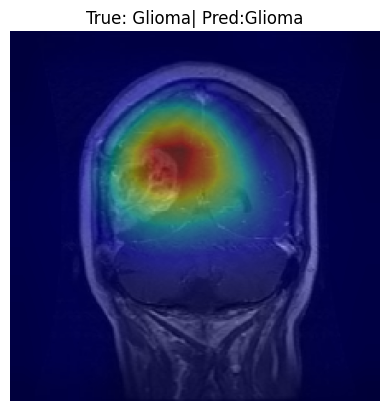

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


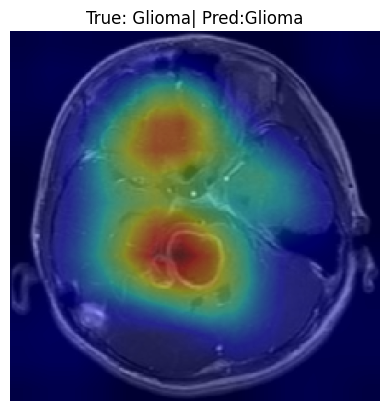

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


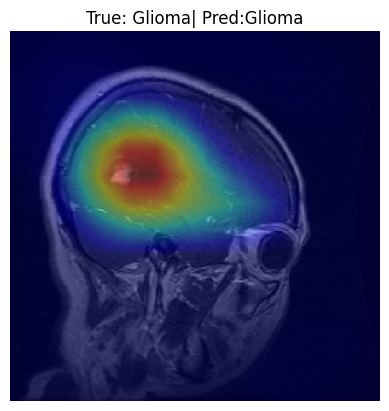

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


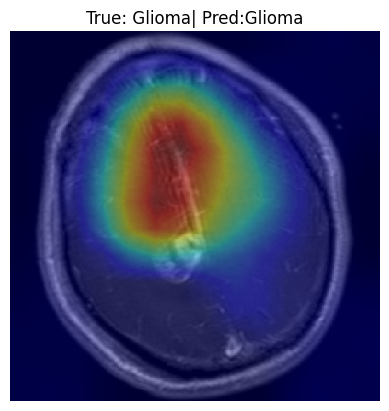

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


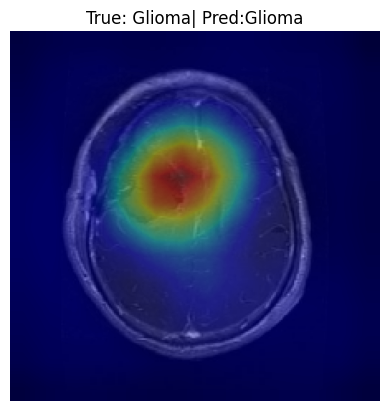

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


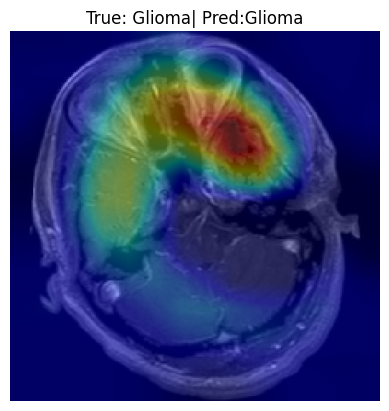

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


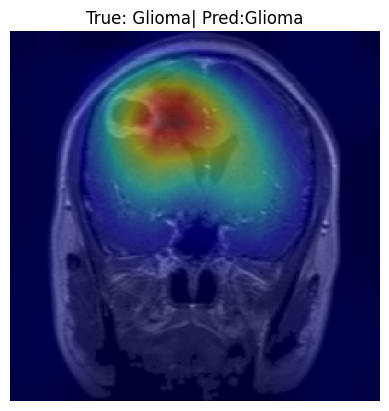

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


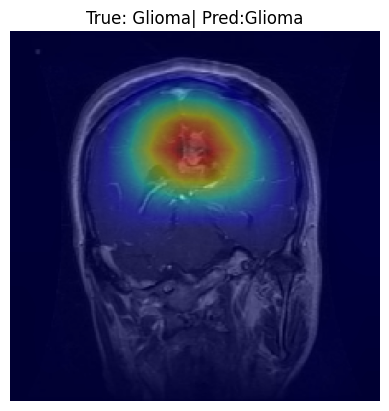

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


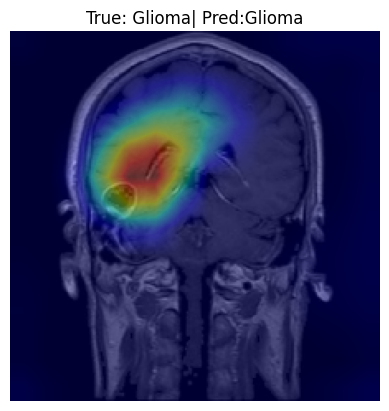

In [118]:
#=================================
# Grad-CAM Visualization
#=================================

for i in range(1,10):
    img_path=df['path'].iloc[i]

    img=tf.keras.preprocessing.image.load_img(img_path,target_size=(224,224))

    img_array=tf.keras.preprocessing.image.img_to_array(img)/255.
    img_array=np.expand_dims(img_array,0)

    # True label for dataFrame
    true_label=df['label'].iloc[i]
    
    # predict
    preds=model.predict(img_array)
    pred_idx=np.argmax(preds)
    pred_label=class_label[pred_idx]
    
    heat=gradcam(model,img_array,layer_name='block5_conv4')
    plt.imshow(img)
    plt.imshow(heat,cmap='jet',alpha=0.4)
    plt.axis('off')
    plt.title(f"True: {true_label}| Pred:{pred_label}")
    plt.show()